
# Named Entity Recognition (NER)
**Goal:** Identify named entities (PERSON, ORG, GPE/LOC, MISC, etc.) in news articles using **rule-based** and **model-based** approaches with spaCy.  
Features:
- Loads CoNLL2003-style files or a CSV of articles.
- Builds a **rule-based** `EntityRuler` with common patterns.
- Runs **model-based** NER using two spaCy models (auto-detected).
- Highlights & categorizes entities in tables and with **displaCy** visualization.
- Evaluates entity extraction against CoNLL gold spans (precision, recall, F1).
- Compares model outputs and shows entity counts.

**Data used:** place either:
- `articles.csv` with a `text` column (no gold labels), or
- A CoNLL-style file like `conll_test.txt` (token POS CHUNK NER per line).

Tools: `spaCy`, `pandas`, `matplotlib`, `displaCy` (comes with spaCy).


## 1) Install dependencies and models

In [ ]:

# Uncomment to install if running in a fresh environment
# %pip install spacy pandas matplotlib
# python -m spacy download en_core_web_sm
# python -m spacy download en_core_web_md
# python -m spacy download en_core_web_trf  # optional; large and requires transformers/torch


## 2) Imports & Setup

In [18]:

import os, re, warnings, itertools
from typing import List, Tuple, Dict, Optional
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,5)

import spacy
from spacy.pipeline import EntityRuler
from spacy import displacy
from IPython.display import display, HTML

warnings.filterwarnings('ignore')


## 3) Auto-detect and load two spaCy models to compare

In [5]:

CANDIDATES = ["en_core_web_md", "en_core_web_sm"]
LOADED = []
for name in CANDIDATES:
    try:
        nlp_tmp = spacy.load(name)
        LOADED.append((name, nlp_tmp))
        print("Loaded", name)
    except Exception as e:
        print("Could not load", name, ":", e)
    if len(LOADED) == 2:
        break

if not LOADED:
    raise RuntimeError("No spaCy models available. Install at least en_core_web_sm.")
# If only one model loaded, duplicate to allow comparison (note: results identical)
if len(LOADED) == 1:
    LOADED = LOADED * 2

MODEL_NAMES = [m[0] for m in LOADED]
print("Models to compare:", MODEL_NAMES)
print(len(LOADED))


Loaded en_core_web_md
Loaded en_core_web_sm
Models to compare: ['en_core_web_md', 'en_core_web_sm']
2
Loaded en_core_web_sm
Models to compare: ['en_core_web_md', 'en_core_web_sm']
2


## 4) Load data

In [8]:
# Try to load articles.csv first; else search for CoNLL-style files
def load_articles_csv(path='articles.csv') -> Optional[pd.DataFrame]:
    if not os.path.exists(path):
        return None
    df = pd.read_csv(path)
    # detect text column
    for c in df.columns:
        if c.lower() in ['text','article','content','body']:
            return df[[c]].rename(columns={c:'text'}).dropna().reset_index(drop=True)
    raise ValueError("CSV found but no text/article column detected. Use 'text' or 'article'.")


def parse_conll(path: str):
    if not os.path.exists(path):
        return None
    sentences = []
    cur_tokens, cur_tags = [], []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("-DOCSTART-"):
                if cur_tokens:
                    sentences.append((cur_tokens, cur_tags))
                    cur_tokens, cur_tags = [], []
                continue
            parts = line.split()
            token = parts[0]
            tag = parts[-1]
            cur_tokens.append(token); cur_tags.append(tag)
    if cur_tokens:
        sentences.append((cur_tokens, cur_tags))

    # convert IOB to spans
    def iob_to_spans(tokens, tags):
        text = " ".join(tokens)
        spans = []
        start_idx = None; cur_label = None; span_start_token = None
        offsets = []
        pos = 0
        for t in tokens:
            start = pos
            end = start + len(t)
            offsets.append((start,end))
            pos = end + 1
        for i, tag in enumerate(tags):
            if tag == 'O':
                if start_idx is not None:
                    s = offsets[span_start_token][0]
                    e = offsets[i-1][1]
                    label = cur_label
                    label = {'PER':'PERSON','LOC':'GPE','ORG':'ORG','MISC':'MISC'}.get(label, label)
                    spans.append((s,e,label))
                    start_idx = None; cur_label = None; span_start_token = None
                continue
            bio_label = tag.split('-',1) if '-' in tag else (tag, None)
            bio = bio_label[0]; label = bio_label[1] if len(bio_label)>1 else None
            if bio == 'B':
                if start_idx is not None:
                    s = offsets[span_start_token][0]; e = offsets[i-1][1]
                    lab = cur_label
                    lab = {'PER':'PERSON','LOC':'GPE','ORG':'ORG','MISC':'MISC'}.get(lab, lab)
                    spans.append((s,e,lab))
                start_idx = offsets[i][0]; span_start_token = i; cur_label = label
            elif bio == 'I' and label == cur_label:
                # continue span
                pass
            else:
                if start_idx is not None:
                    s = offsets[span_start_token][0]; e = offsets[i-1][1]
                    lab = cur_label
                    lab = {'PER':'PERSON','LOC':'GPE','ORG':'ORG','MISC':'MISC'}.get(lab, lab)
                    spans.append((s,e,lab))
                start_idx = None; cur_label = None; span_start_token = None
        if start_idx is not None:
            s = offsets[span_start_token][0]; e = offsets[len(tokens)-1][1]
            lab = cur_label
            lab = {'PER':'PERSON','LOC':'GPE','ORG':'ORG','MISC':'MISC'}.get(lab, lab)
            spans.append((s,e,lab))
        return text, spans

    docs = []
    for tokens,tags in sentences:
        text, spans = iob_to_spans(tokens, tags)
        docs.append({'text': text, 'entities': spans})
    return docs


articles = load_articles_csv('articles.csv')
gold_docs = None
if articles is not None:
    print("Loaded articles.csv with", len(articles), "rows")
else:
    # Prefer CoNLL2003 files from datasets/CoNLL003 in this workspace
    search_roots = [
        '.',
        os.path.join('datasets','CoNLL003'),
        os.path.join('datasets','CoNLL2003'),
        'CoNLL003',
    ]
    # Prefer test, then valid/dev, then common CoNLL file names, then train as last resort
    search_files = [
        'test.txt',
        'valid.txt',
        'train.txt',
    ]
    loaded_path = None
    for root in search_roots:
        for fname in search_files:
            candidate = os.path.join(root, fname)
            parsed = parse_conll(candidate)
            if parsed:
                gold_docs = parsed
                loaded_path = candidate
                break
        if gold_docs is not None:
            break
    if loaded_path:
        print("Loaded CoNLL-style file:", loaded_path, "with", len(gold_docs), "sentences")

if articles is None and gold_docs is None:
    raise FileNotFoundError("No data found. Provide articles.csv (with 'text') or a CoNLL-style file (e.g., datasets/CoNLL003/test.txt).")


Loaded CoNLL-style file: datasets\CoNLL003\test.txt with 3453 sentences


## 5) Build a rule-based EntityRuler and apply to texts

In [11]:


def build_entity_ruler(nlp, overwrite_ents=False):
    # Remove if already present to keep re-runs safe
    if 'entity_ruler_custom' in nlp.pipe_names:
        nlp.remove_pipe('entity_ruler_custom')
    # Add via factory string (spaCy v3+)
    ruler = nlp.add_pipe(
        'entity_ruler',
        name='entity_ruler_custom',
        last=True,
        config={'overwrite_ents': overwrite_ents}
    )
    patterns = []
    org_suffixes = ["Inc", "Inc.", "Corp", "Corp.", "Corporation", "LLC", "Ltd", "Ltd.", "University", "Institute", "Group", "Co.", "Company"]
    for suf in org_suffixes:
        patterns.append({'label':'ORG', 'pattern':[{'IS_TITLE':True, 'OP':'+'}, {'TEXT':suf}]})
    titles = ["Mr.", "Mrs.", "Ms.", "Dr.", "Prof.", "President", "Prime Minister", "Sir"]
    for t in titles:
        patterns.append({'label':'PERSON', 'pattern':[{'TEXT':t}, {'IS_TITLE':True, 'OP':'+'}]})
    gpes = ["United States", "U.S.", "USA", "United Kingdom", "UK", "New York", "London", "Paris", "Berlin", "Tokyo"]
    for g in gpes:
        patterns.append({'label':'GPE', 'pattern':g})
    orgs = ["United Nations", "European Union", "Apple Inc", "Google", "Microsoft", "Facebook", "Twitter"]
    for o in orgs:
        patterns.append({'label':'ORG', 'pattern':o})
    ruler.add_patterns(patterns)
    return ruler

# Attach ruler to a separate model instance (do not modify original model pipelines)
try:
    # Some spaCy versions support Language.copy(); try first
    ruler_model = LOADED[0][1].copy()
except Exception:
    # Reload by name to ensure independence; fallback to blank English if needed
    try:
        ruler_model = spacy.load(LOADED[0][0])
    except Exception:
        warnings.warn("Falling back to spacy.blank('en') for ruler model; results may differ.")
        ruler_model = spacy.blank("en")

ruler = build_entity_ruler(ruler_model, overwrite_ents=False)
print("EntityRuler added to ruler_model (copy of {})".format(LOADED[0][0]))


EntityRuler added to ruler_model (copy of en_core_web_md)


## 6) Run model-based NER on texts (both models)

In [12]:

# Choose texts input: articles DataFrame or gold_docs (CoNLL)
if articles is not None:
    texts = articles['text'].astype(str).tolist()
else:
    texts = [d['text'] for d in gold_docs]

def run_ner(nlp, texts, batch_size=32):
    docs = list(nlp.pipe(texts, batch_size=batch_size))
    results = []
    for doc in docs:
        ents = [(ent.text, ent.label_, ent.start_char, ent.end_char) for ent in doc.ents]
        results.append(ents)
    return results

# Run rule-based ruler_model and the two loaded models
print("Running rule-based ruler on texts...")
ruler_results = run_ner(ruler_model, texts)
model_results = {}
for name, nlp_model in LOADED:
    print("Running model:", name)
    model_results[name] = run_ner(nlp_model, texts)
print("Done running NER on texts. Sample counts (first text):")
print("Rule-based ents:", len(ruler_results[0]))
for name in model_results:
    print(name, "ents:", len(model_results[name][0]))


Running rule-based ruler on texts...
Running model: en_core_web_md
Running model: en_core_web_md
Running model: en_core_web_sm
Running model: en_core_web_sm
Done running NER on texts. Sample counts (first text):
Rule-based ents: 2
en_core_web_md ents: 2
en_core_web_sm ents: 1
Done running NER on texts. Sample counts (first text):
Rule-based ents: 2
en_core_web_md ents: 2
en_core_web_sm ents: 1


## 7) Display extracted entities in a DataFrame

In [13]:

def entities_to_df(ents_list, texts, model_name):
    rows = []
    for i, ents in enumerate(ents_list):
        for text, label, s, e in ents:
            rows.append({'model': model_name, 'sample_id': i, 'entity': text, 'label': label, 'start': s, 'end': e, 'context_snippet': texts[i][max(0,s-40):min(len(texts[i]), e+40)]})
    return pd.DataFrame(rows)

# show first 5 samples for each model
sample_rows = []
for name in ['rule_based'] + MODEL_NAMES:
    if name == 'rule_based':
        df_ent = entities_to_df(ruler_results, texts, 'rule_based')
    else:
        df_ent = entities_to_df(model_results[name], texts, name)
    print("\n=== Sample entities from", name, "===")
    display(df_ent.head(10))



=== Sample entities from rule_based ===


,model,sample_id,entity,label,start,end,context_snippet
0,rule_based,0,SOCCER - JAPAN,ORG,0,14,"SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRI..."
1,rule_based,0,SURPRISE,GPE,40,48,"SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRI..."
2,rule_based,1,Nadim Ladki,PERSON,0,11,Nadim Ladki
3,rule_based,2,AL-AIN,ORG,0,6,"AL-AIN , United Arab Emirates 1996-12-06"
4,rule_based,2,United Arab Emirates,GPE,9,29,"AL-AIN , United Arab Emirates 1996-12-06"
5,rule_based,2,12-06,CARDINAL,35,40,"AL-AIN , United Arab Emirates 1996-12-06"
6,rule_based,3,Japan,GPE,0,5,Japan began the defence of their Asian Cup ti
7,rule_based,3,Asian Cup,EVENT,33,42,Japan began the defence of their Asian Cup tit...
8,rule_based,3,2,CARDINAL,62,63,e of their Asian Cup title with a lucky 2-1 wi...
9,rule_based,3,Syria,GPE,78,83,Cup title with a lucky 2-1 win against Syria ...



=== Sample entities from en_core_web_md ===


,model,sample_id,entity,label,start,end,context_snippet
0,en_core_web_md,0,SOCCER - JAPAN,ORG,0,14,"SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRI..."
1,en_core_web_md,0,SURPRISE,GPE,40,48,"SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRI..."
2,en_core_web_md,1,Nadim Ladki,PERSON,0,11,Nadim Ladki
3,en_core_web_md,2,AL-AIN,ORG,0,6,"AL-AIN , United Arab Emirates 1996-12-06"
4,en_core_web_md,2,United Arab Emirates,GPE,9,29,"AL-AIN , United Arab Emirates 1996-12-06"
5,en_core_web_md,2,12-06,CARDINAL,35,40,"AL-AIN , United Arab Emirates 1996-12-06"
6,en_core_web_md,3,Japan,GPE,0,5,Japan began the defence of their Asian Cup ti
7,en_core_web_md,3,Asian Cup,EVENT,33,42,Japan began the defence of their Asian Cup tit...
8,en_core_web_md,3,2,CARDINAL,62,63,e of their Asian Cup title with a lucky 2-1 wi...
9,en_core_web_md,3,Syria,GPE,78,83,Cup title with a lucky 2-1 win against Syria ...



=== Sample entities from en_core_web_sm ===


,model,sample_id,entity,label,start,end,context_snippet
0,en_core_web_sm,0,DEFEAT,ORG,49,55,"JAPAN GET LUCKY WIN , CHINA IN SURPRISE DEFEAT ."
1,en_core_web_sm,1,Nadim Ladki,PERSON,0,11,Nadim Ladki
2,en_core_web_sm,2,AL-AIN,ORG,0,6,"AL-AIN , United Arab Emirates 1996-12-06"
3,en_core_web_sm,2,United Arab Emirates,GPE,9,29,"AL-AIN , United Arab Emirates 1996-12-06"
4,en_core_web_sm,2,1996-12-06,DATE,30,40,"AL-AIN , United Arab Emirates 1996-12-06"
5,en_core_web_sm,3,Japan,GPE,0,5,Japan began the defence of their Asian Cup ti
6,en_core_web_sm,3,Asian Cup,EVENT,33,42,Japan began the defence of their Asian Cup tit...
7,en_core_web_sm,3,2,CARDINAL,62,63,e of their Asian Cup title with a lucky 2-1 wi...
8,en_core_web_sm,3,Syria,GPE,78,83,Cup title with a lucky 2-1 win against Syria ...
9,en_core_web_sm,3,Group C,ORG,89,96,with a lucky 2-1 win against Syria in a Group ...


## 8) Visualize entities with displaCy (inline)

In [20]:
# Display first N texts side-by-side for each model using displacy in notebook
N = 3
for model_name, nlp_model in LOADED:
    print(f"\n--- displaCy visualizations for {model_name} ---\n")
    docs = list(nlp_model.pipe(texts[:N]))
    for i, d in enumerate(docs):
        print(f"Sample {i} ({model_name})\n")
        # Show the Doc repr
        display(d)
        # Render HTML manually and display to avoid spaCy's internal IPython import
        html = displacy.render(d, style='ent', jupyter=False, options={'compact': True})
        display(HTML(html))



--- displaCy visualizations for en_core_web_md ---

Sample 0 (en_core_web_md)



SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRISE DEFEAT .

Sample 1 (en_core_web_md)



Nadim Ladki

Sample 2 (en_core_web_md)



AL-AIN , United Arab Emirates 1996-12-06


--- displaCy visualizations for en_core_web_sm ---

Sample 0 (en_core_web_sm)



SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRISE DEFEAT .

Sample 1 (en_core_web_sm)



Nadim Ladki

Sample 2 (en_core_web_sm)



AL-AIN , United Arab Emirates 1996-12-06

## 9) Evaluate against CoNLL gold spans (precision, recall, F1)

In [21]:

from collections import Counter

def score_predictions(pred_spans, gold_spans):
    # pred_spans and gold_spans: lists of (start,end,label)
    pred_set = set(pred_spans)
    gold_set = set(gold_spans)
    tp = len(pred_set & gold_set)
    fp = len(pred_set - gold_set)
    fn = len(gold_set - pred_set)
    prec = tp / (tp + fp) if (tp + fp) else 0.0
    rec = tp / (tp + fn) if (tp + fn) else 0.0
    f1 = 2*prec*rec/(prec+rec) if (prec+rec) else 0.0
    return {'tp':tp,'fp':fp,'fn':fn,'precision':prec,'recall':rec,'f1':f1}

if gold_docs is not None:
    # compute scores per model (exact span+label match)
    scores = []
    for name in ['rule_based'] + MODEL_NAMES:
        total_tp=total_fp=total_fn=0
        model_spans = ruler_results if name=='rule_based' else model_results[name]
        for i, gold in enumerate(gold_docs):
            gold_spans = gold['entities']  # list of (s,e,label)
            pred_spans = [(s,e,l) for (t,l,s,e) in model_spans[i]]
            res = score_predictions(pred_spans, gold_spans)
            total_tp += res['tp']; total_fp += res['fp']; total_fn += res['fn']
        prec = total_tp/(total_tp+total_fp) if (total_tp+total_fp) else 0.0
        rec = total_tp/(total_tp+total_fn) if (total_tp+total_fn) else 0.0
        f1 = 2*prec*rec/(prec+rec) if (prec+rec) else 0.0
        scores.append({'model':name,'precision':round(prec,4),'recall':round(rec,4),'f1':round(f1,4),'tp':total_tp,'fp':total_fp,'fn':total_fn})
    scores_df = pd.DataFrame(scores).sort_values('f1',ascending=False)
    display(scores_df)
else:
    print('No gold CoNLL data available; skip evaluation.')


,model,precision,recall,f1,tp,fp,fn
0,rule_based,0.3262,0.5080,0.3973,2869,5925,2779
1,en_core_web_md,0.3261,0.5076,0.3971,2867,5924,2781
2,en_core_web_sm,0.3114,0.4770,0.3768,2694,5958,2954


## 10) Entity counts and comparison summary

,model,label,count
0,en_core_web_md,CARDINAL,1885
1,en_core_web_md,DATE,1141
2,en_core_web_md,EVENT,91
3,en_core_web_md,FAC,33
4,en_core_web_md,GPE,1834
5,en_core_web_md,LANGUAGE,7
6,en_core_web_md,LAW,8
7,en_core_web_md,LOC,69
8,en_core_web_md,MONEY,173
9,en_core_web_md,NORP,424


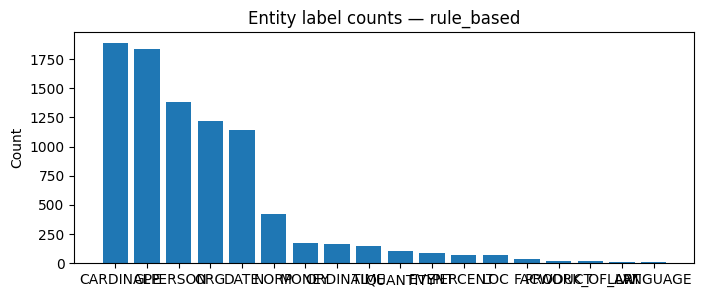

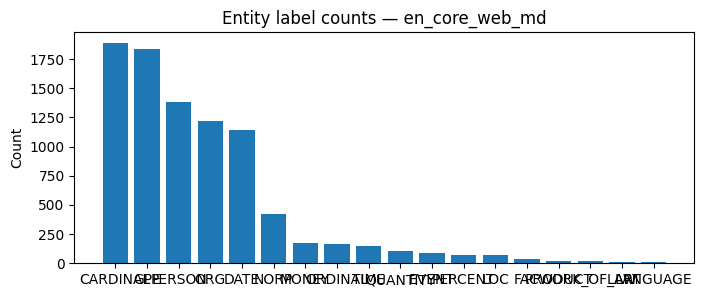

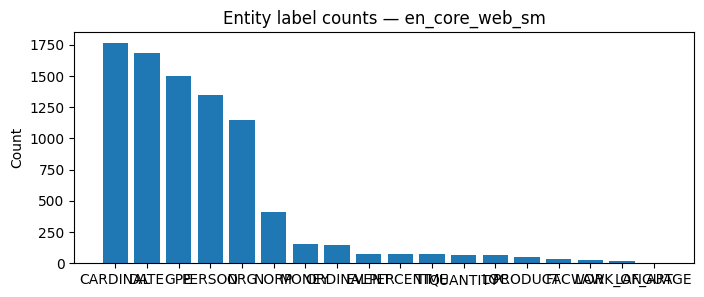

In [23]:

from collections import Counter

def entity_counts(model_spans, model_name):
    # model_spans is List[List[(text, label, start, end)]]
    labels = [label for doc_ents in model_spans for (_, label, _, _) in doc_ents]
    c = Counter(labels)
    return pd.DataFrame.from_records(list(c.items()), columns=['label','count']).assign(model=model_name).sort_values('count',ascending=False)

all_counts = []
# rule-based
all_counts.append(entity_counts(ruler_results, 'rule_based'))
for name in MODEL_NAMES:
    all_counts.append(entity_counts(model_results[name], name))

counts_df = pd.concat(all_counts, ignore_index=True)
display(counts_df.groupby(['model','label']).sum().reset_index().sort_values(['model','label']))
# simple bar plot per model
for model in counts_df['model'].unique():
    sub = counts_df[counts_df['model']==model].sort_values('count',ascending=False)
    plt.figure(figsize=(8,3))
    plt.bar(sub['label'], sub['count'])
    plt.title(f'Entity label counts — {model}')
    plt.ylabel('Count')
    plt.show()


## 11) Inspect most informative / discrepant entities between models

In [24]:

# Show entities that one model found but the other did not for the first N samples
def discrepant_entities(name_a, name_b, idx=0):
    a_spans = set((t,l) for (t,l,s,e) in (ruler_results[idx] if name_a=='rule_based' else model_results[name_a][idx]))
    b_spans = set((t,l) for (t,l,s,e) in (ruler_results[idx] if name_b=='rule_based' else model_results[name_b][idx]))
    only_a = a_spans - b_spans
    only_b = b_spans - a_spans
    return only_a, only_b

for i in range(min(3, len(texts))):
    print(f"--- Sample {i} ---")
    a_only, b_only = discrepant_entities(MODEL_NAMES[0], MODEL_NAMES[1], idx=i)
    print(f"Only in {MODEL_NAMES[0]}:", a_only)
    print(f"Only in {MODEL_NAMES[1]}:", b_only)
    print()


--- Sample 0 ---
Only in en_core_web_md: {('SURPRISE', 'GPE'), ('SOCCER - JAPAN', 'ORG')}
Only in en_core_web_sm: {('DEFEAT', 'ORG')}

--- Sample 1 ---
Only in en_core_web_md: set()
Only in en_core_web_sm: set()

--- Sample 2 ---
Only in en_core_web_md: {('12-06', 'CARDINAL')}
Only in en_core_web_sm: {('1996-12-06', 'DATE')}



## 12) Save results & export CSV

In [25]:

# Save entity tables for further analysis
out_dir = "ner_outputs"
os.makedirs(out_dir, exist_ok=True)
for name in ['rule_based'] + MODEL_NAMES:
    if name == 'rule_based':
        df_ent = entities_to_df(ruler_results, texts, 'rule_based')
    else:
        df_ent = entities_to_df(model_results[name], texts, name)
    path = os.path.join(out_dir, f"entities_{name}.csv")
    df_ent.to_csv(path, index=False)
    print("Wrote", path)
print("All outputs saved to", out_dir)


Wrote ner_outputs\entities_rule_based.csv
Wrote ner_outputs\entities_en_core_web_md.csv
Wrote ner_outputs\entities_en_core_web_sm.csv
All outputs saved to ner_outputs


## 13) Test Models

In [1]:
# Create a Streamlit app to test the NER models interactively
from pathlib import Path
from textwrap import dedent

app_code = dedent('''
import warnings
import pandas as pd
import spacy
from spacy.pipeline import EntityRuler
from spacy import displacy
import streamlit as st

st.set_page_config(page_title="NER App", layout="wide")

CANDIDATES = ["en_core_web_md", "en_core_web_sm"]


def build_entity_ruler(nlp, overwrite_ents=False):
    if "entity_ruler_custom" in nlp.pipe_names:
        nlp.remove_pipe("entity_ruler_custom")
    ruler = nlp.add_pipe(
        "entity_ruler",
        name="entity_ruler_custom",
        last=True,
        config={"overwrite_ents": overwrite_ents},
    )
    patterns = []
    org_suffixes = [
        "Inc",
        "Inc.",
        "Corp",
        "Corp.",
        "Corporation",
        "LLC",
        "Ltd",
        "Ltd.",
        "University",
        "Institute",
        "Group",
        "Co.",
        "Company",
    ]
    for suf in org_suffixes:
        patterns.append({"label": "ORG", "pattern": [{"IS_TITLE": True, "OP": "+"}, {"TEXT": suf}]})
    titles = ["Mr.", "Mrs.", "Ms.", "Dr.", "Prof.", "President", "Prime Minister", "Sir"]
    for t in titles:
        patterns.append({"label": "PERSON", "pattern": [{"TEXT": t}, {"IS_TITLE": True, "OP": "+"}]})
    gpes = [
        "United States",
        "U.S.",
        "USA",
        "United Kingdom",
        "UK",
        "New York",
        "London",
        "Paris",
        "Berlin",
        "Tokyo",
    ]
    for g in gpes:
        patterns.append({"label": "GPE", "pattern": g})
    orgs = ["United Nations", "European Union", "Apple Inc", "Google", "Microsoft", "Facebook", "Twitter"]
    for o in orgs:
        patterns.append({"label": "ORG", "pattern": o})
    ruler.add_patterns(patterns)
    return ruler


@st.cache_resource(show_spinner=False)
def load_models():
    loaded = {}
    # Load candidate spaCy models if available
    for name in CANDIDATES:
        try:
            loaded[name] = spacy.load(name)
        except Exception:
            pass

    # Select a base model for the rule-based pipeline
    base = None
    base_name = None
    if loaded:
        base_name, base = next(iter(loaded.items()))
    else:
        base_name = "blank_en"
        base = spacy.blank("en")
        warnings.warn("Using spacy.blank('en') because no pre-trained models were found.")

    # Build an independent ruler model
    try:
        ruler_model = base.copy()
    except Exception:
        try:
            ruler_model = spacy.load(base_name) if base_name != "blank_en" else spacy.blank("en")
        except Exception:
            ruler_model = spacy.blank("en")

    build_entity_ruler(ruler_model, overwrite_ents=False)
    loaded = {"rule_based": ruler_model, **loaded}
    return loaded


models = load_models()
model_names = list(models.keys())

st.title("Named Entity Recognition")
st.write(
    "Type or paste text and compare NER models, including a rule-based EntityRuler."
)

col1, col2 = st.columns([3, 1])
with col2:
    model_choice = st.selectbox("Model", model_names, index=0)
    max_chars = st.slider("Max text length", 100, 5000, 1000, 100)
with col1:
    default_text = (
        "Apple Inc. hired Dr. John Smith in New York to lead AI research for the European Union."
    )
    text = st.text_area("Input text", default_text, height=200, max_chars=max_chars)

if st.button("Analyze"):
    nlp = models[model_choice]
    doc = nlp(text)
    ents = [
        {"text": ent.text, "label": ent.label_, "start": ent.start_char, "end": ent.end_char}
        for ent in doc.ents
    ]
    df = pd.DataFrame(ents)

    if df.empty:
        st.info("No entities found.")
    else:
        labels = sorted(df["label"].unique().tolist())
        selected = st.multiselect("Filter labels", labels, default=labels)
        st.subheader("Entities")
        st.dataframe(df[df["label"].isin(selected)], use_container_width=True)

    # Render highlighted entities
    html = displacy.render(doc, style="ent", options={"compact": True})
    st.subheader("Highlighted text")
    st.components.v1.html(html, height=250, scrolling=True)
''').strip()

Path("Named-Entity-Recognition.py").write_text(app_code, encoding="utf-8")
print("Wrote Named-Entity-Recognition.py")
print("\nHow to launch (Windows PowerShell):")
print("1) Activate your environment (if needed):")
print("   .\\myenv\\Scripts\\Activate.ps1")
print("2) Run Streamlit:")
print("   .\\myenv\\Scripts\\streamlit.exe run Named-Entity-Recognition.py")
print("   # Or simply: streamlit run Named-Entity-Recognition.py")
print("\nTip: Install models if missing:")
print("   python -m spacy download en_core_web_sm; python -m spacy download en_core_web_md")

Wrote Named-Entity-Recognition.py

How to launch (Windows PowerShell):
1) Activate your environment (if needed):
   .\myenv\Scripts\Activate.ps1
2) Run Streamlit:
   .\myenv\Scripts\streamlit.exe run Named-Entity-Recognition.py
   # Or simply: streamlit run Named-Entity-Recognition.py

Tip: Install models if missing:
   python -m spacy download en_core_web_sm; python -m spacy download en_core_web_md


## 14) Next steps and tips
- Improve EntityRuler patterns by loading lists from files (e.g., countries, company suffixes, common organizations).
- For higher-quality results, fine-tune a spaCy NER component on your labeled CoNLL data.
- Use partial-overlap scoring (IOU) for more forgiving evaluation when spans differ slightly.
- Use the transformer-based model (en_core_web_trf) if available for best accuracy in many cases.
